In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

The notebook contains the functions used to deal with multipartite graphs - taken from the work we did with microsoft. 

Generally - the functions will take in and out 2 things: 
- the matrix or the embedding
- attributes: two lists, each a dictionary containing information about the rows/columns respectively. 

would be good if: 
* no time results in no time in partitions 
* can specify a weight column 
* how does it so far relate to LMM data? - check with time series data

In [2]:
# replace with own path to data folder:
# path = 'path_to_data_folder'
# path = '/home/ag16115/Documents/phd/codebase_data/brazil'

# data types

In [3]:
from preprocessing import *
from embedding import *
from misc import *

## dynamic - lyon school 

In [4]:
# tables = [pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'T': [1, 2, 3]}), pd.DataFrame({
#             'C': [7, 8, 9], 'D': [10, 11, 12], 'T': [1, 2, 3]})]
# relationships = [['A', 'B'], ['C', 'D']]
# time_col = 'T'
# join_token = '::'

In [39]:
df1 = pd.DataFrame(
    {'A': [1, 2, 3], 'B': [7, 9, 6], 'C': [2,3,4], 'ID': [10, 11, 12]})
df2 = pd.DataFrame(
    {'B': [7, 8, 9], 'C': [10, 11, 12], 'ID': [13, 14, 15]})
tables = [df1, df2]

In [40]:
relationships = [['A', 'B'], ['B', 'C']]
time_col = 'ID'

In [42]:
A1, attributes1 = matrix_from_tables(tables, relationships, time_col = time_col, join_token='::')

['A', 'B']
['B', 'C']
['B', 'C']


In [43]:
relationships = [[['A', 'B'], ['B', 'C']],[['B' ,'C']]]
time_col = ['ID','ID']

In [44]:
A2, attributes2 = matrix_from_tables(tables, relationships, time_col = time_col, join_token='::')

['A', 'B']
['B', 'C']
['B', 'C']


In [45]:
## see if A1 and A2 are the same    
print(np.allclose(A1.toarray(),A2.toarray()))


True


In [47]:
A1.shape

(13, 78)

In [50]:
[att if att['parition'] == 'A' for att in attributes1[1]]

SyntaxError: invalid syntax (1666528586.py, line 1)

In [57]:
        df1 = pd.DataFrame(
            {'A': [1, 2, 3], 'B': [7, 9, 6], 'C': [2, 3, 4], 'ID': [10, 11, 12]})
        df2 = pd.DataFrame(
            {'B': [7, 8, 9], 'C': [10, 11, 12], 'ID': [13, 14, 15]})
        tables = [df1, df2]

        relationships1 = [['A', 'B'], ['B', 'C']]
        time_col1 = 'ID'
        A1, attributes1 = matrix_from_tables(
            tables, relationships1, time_col=time_col1, join_token='::')

        relationships2 = [[['A', 'B'], ['B', 'C']], [['B', 'C']]]
        time_col2 = ['ID', 'ID']
        A2, attributes2 = matrix_from_tables(
            tables, relationships2, time_col=time_col2, join_token='::')

        print(np.allclose(A1.toarray(), A2.toarray()))
        print(attributes1 == attributes2)
        print(A1.shape == (13, 78))
        print(A1.shape ==  (len(attributes1[0]), len(attributes1[1])))


['A', 'B']
['B', 'C']
['B', 'C']
['A', 'B']
['B', 'C']
['B', 'C']
True
True
True
True


In [54]:
        df1 = pd.DataFrame(
            {'A': [1, 2, 3], 'B': [7, 9, 6], 'C': [2, 3, 4], 'ID': [10, 11, 12]})
        df2 = pd.DataFrame(
            {'B': [7, 8, 9], 'C': [10, 11, 12], 'ID': [13, 14, 15]})
        tables = [df1, df2]

        relationships = [['A', 'B'], ['B', 'C']]
        time_col = 'ID'
        A1, attributes1 = matrix_from_tables(
            tables, relationships, time_col=time_col, join_token='::')
        print(A1.shape)

        relationships = [[['A', 'B'], ['B', 'C']], [['B', 'C']]]
        time_col = ['ID', 'ID']
        A2, attributes2 = matrix_from_tables(
            tables, relationships, time_col=time_col, join_token='::')

['A', 'B']
['B', 'C']
['B', 'C']
(13, 78)
['A', 'B']
['B', 'C']
['B', 'C']


In [55]:
A1.shape

(13, 78)

In [51]:
len(attributes1[1])

78

In [46]:
## see if attributes1 and attributes2 are the same  
print(attributes1 == attributes2)  

True


In [5]:
# matrix_from_tables(tables, relationships, time_col=time_col, join_token='::')

In [6]:
# load data 
# need the activity_data.csv file
path = '/home/ag16115/Documents/phd/codebase_data/'
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges', sep = ',', on_bad_lines='skip', header = None)
# data = pd.read_csv(path + '/activity_data.csv', sep = '\t', on_bad_lines='skip')

In [7]:
## rename columns   
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
## sort out time column
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [10*int(i/24) + i%24 - 8 for i in list(data['H'])]

In [8]:
def scree_plot(A, s = 1, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=50)
    SA = SA[::-1]

In [9]:
def scree_plot(A, k = 50, s = 10, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=k)
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(SA)), np.sort(SA)[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)
        
# def subspace_scree_plots(embeddings, s = 1, vlines=None):
#     fig, axs = plt.subplots(len(embeddings), figsize=(12,4*len(embeddings)))
#     fig.patch.set_facecolor('white')
#     for i, p in enumerate(embeddings.keys()):
#         axs[i].title.set_text(p)
#         axs[i].scatter(range(len(embeddings[p].metadata['partition singular values'])), np.sort(embeddings[p].metadata['partition singular values'])[::-1], s =s)
#         if vlines:
#             axs[i].axvline(x=vlines[i], color='green', linewidth=0.5)

In [11]:
A, attributes = matrix_from_tables(data, ['V1','V2'], time_col='T', join_token='::')

['V1', 'V2']


In [ ]:
A 

<242x4840 sparse matrix of type '<class 'numpy.float64'>'
	with 52702 stored elements in Compressed Sparse Row format>

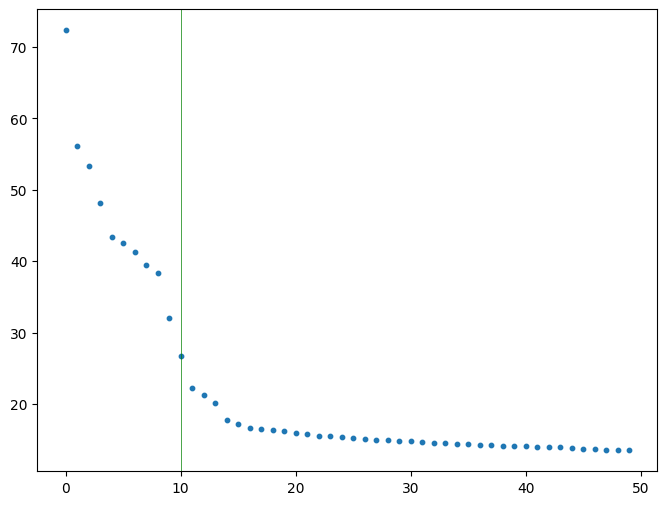

In [ ]:
d = 10
scree_plot(A, k = 50,s = d, vline=10)

In [ ]:
d = 10
embedding = embed(A, d = d, matrix = 'adjacency', regulariser = 0)
LHS = embedding[0]  
RHS = embedding[1]  

LHS = degree_correction(LHS)      
RHS = degree_correction(RHS)  


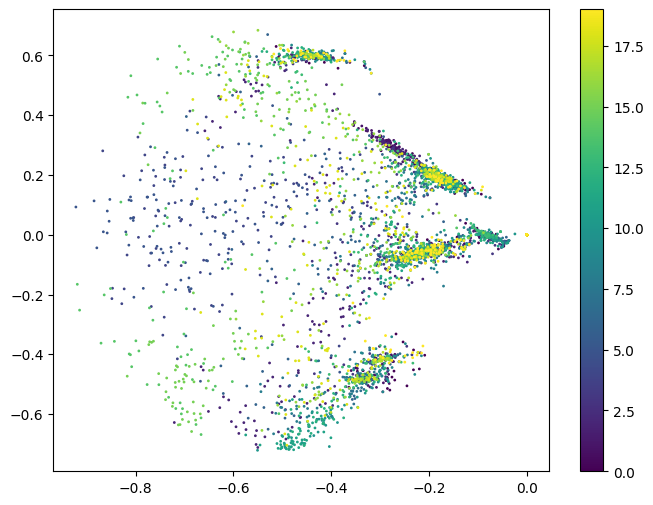

In [ ]:
## plot the right hand side embedding and colour by time    
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')   
plt.scatter(RHS[:,0], RHS[:,1], c = [att['time'] for att in attributes[1]], s = 1, cmap = 'viridis')    
plt.colorbar()
plt.show()
    


## multipartite - brazil

The data contains information about the procurement process in Brazil. Each row contains information about a tender with information:
- Tender: tender id
- Period: time 
- Buyer: who is funding
- Item: what the tender is abour 
- Company: who has bid for the tender
- bidder_win: whether the bid was won or not

In [ ]:
data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')
A, attributes = matrix_from_tables(data, [['Company', 'Tender'],['Company', 'Buyer'],['Company', 'Item']],time_col = 'Period', join_token='::')

/tmp/ipykernel_39181/349976679.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')


['Company', 'Tender']
['Company', 'Buyer']
['Company', 'Item']


In [ ]:
# find subgraph wanted

subgraph_attributes = [
    [{'partition': 'Company'},{'partition': 'Tender'}],
    {'partition': 'Buyer'}
]

# subgraph_attributes = [
#     {'partition': 'Company'},
#     {'partition': 'Buyer'}
# ]
subgraph_A, subgraph_attributes  = find_subgraph(A, attributes,subgraph_attributes)

In [ ]:
# A_dilation = symmetric_dilation(subgraph_A)
# is_symmetric(A_dilation)

In [ ]:
# take the largest connected component
cc_A, cc_attributes = find_connected_components(subgraph_A, subgraph_attributes,n_components = 1)

In [ ]:
    for data0, relationships0, time_col0 in zip(tables, relationships, time_col):
        for partition_pair in relationships0:

In [ ]:
# G = to_networkx(cc_A, cc_attributes)
# G.number_of_nodes()
# G.nodes[1]
# list(G.nodes)

In [ ]:
# get left and right embeddings
left_embed, right_embed = embed(cc_A, matrix = 'laplacian')
# the attributes associated with left_embed and right_embed are cc_attributes[0] and cc_attributes[1]
left_attributes = cc_attributes[0]
right_attributes = cc_attributes[1]

In [ ]:
partition_embeddings, partition_attributes = recover_subspaces(left_embed,left_attributes)

In [ ]:
partition_embeddings['Company'] = degree_correction(partition_embeddings['Company'])